# gyro-interp using nexsci data with multiple age references

See `code_gyrointerp_nexsci2.ipynb` for the adopted data.

In [1]:
import sys

# make sure you are using `gyrointerp` environment
assert sys.executable.split('/')[5]=='gyrointerp'

In [2]:
# Inside this jupyter lab, do not use `pip install xxx`, instead use:
# import sys
# !{sys.executable} -m pip install xxx

In [3]:
# check if package is installed
!{sys.executable} -m pip show gyrointerp

Name: gyrointerp
Version: 0.5
Summary: Gyrochronology via interpolation of open cluster rotation sequences.
Home-page: https://github.com/lgbouma/gyro-interp
Author: Luke Bouma
Author-email: bouma.luke@gmail.com
License: MIT
Location: /mnt_ut3/raid_ut3/home/jerome/github/research/project/ext_tools/gyro-interp
Editable project location: /mnt_ut3/raid_ut3/home/jerome/github/research/project/ext_tools/gyro-interp
Requires: astropy, matplotlib, numpy, pandas, scipy
Required-by: 


In [4]:
# import custom code from the `code` directory
import sys
sys.path.insert(0, '../code')

## load nexsci data

In [5]:
from kenmon import get_nexsci_data

# set clobber=True to update data (takes > 5 mins)
known_planets = get_nexsci_data(table_name='ps', clobber=False)
known_planets

Column definitions:  https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html
Loaded:  ../data/nexsci_pscomppars.csv


,objectid,pl_name,pl_letter,hostid,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,...,pl_angseperr1,pl_angseperr2,pl_angseplim,pl_angsepformat,pl_angsepstr,pl_angsepsymerr,pl_angsep_reflink,pl_ndispec,sky_coord.ra,sky_coord.dec
0,3.34990,Kepler-24 e,e,2.424906,Kepler-24,NaN,NaN,TIC 122376177,2014-03,2014,...,NaN,NaN,0.0,NaN,0.1190,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,290.413262,38.343728
1,3.24410,Kepler-1065 b,b,2.430631,Kepler-1065,NaN,NaN,TIC 378012771,2016-05,2016,...,NaN,NaN,0.0,NaN,0.0405,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,294.511319,38.790465
2,3.12740,TOI-1260 c,c,2.572931,TOI-1260,NaN,NaN,TIC 355867695,2021-08,2021,...,NaN,NaN,0.0,NaN,0.8930,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,157.144071,65.854199
3,3.13149,HD 28109 c,c,2.573080,HD 28109,HD 28109,NaN,TIC 29781292,2022-05,2022,...,NaN,NaN,0.0,NaN,2.2100,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,65.238306,-68.102688
4,3.12788,K2-350 b,b,2.208571,K2-350,NaN,NaN,TIC 294319820,2021-08,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,204.035509,-14.009252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4355,3.11878,TRAPPIST-1 d,d,2.103803,TRAPPIST-1,NaN,NaN,TIC 278892590,2016-05,2016,...,NaN,NaN,0.0,NaN,1.7900,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,346.626392,-5.043462
4356,3.10200,EPIC 201595106 b,b,2.797590,EPIC 201595106,NaN,NaN,TIC 397052808,2021-08,2021,...,NaN,NaN,0.0,NaN,0.0763,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,183.720363,1.968169
4357,3.19930,Kepler-974 b,b,2.452484,Kepler-974,NaN,NaN,TIC 120418600,2016-05,2016,...,NaN,NaN,0.0,NaN,0.3120,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,285.013108,40.220955
4358,3.20123,KOI-1843.03,c,2.452484,Kepler-974,NaN,NaN,TIC 120418600,2013-08,2013,...,NaN,NaN,0.0,NaN,0.0372,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,285.013108,40.220955


In [6]:
# how many stars have st_rotp?
known_planets['st_rotp'].dropna().shape

(444,)

In [7]:
# how many stars have st_teff?
known_planets['st_teff'].dropna().shape

(4358,)

In [8]:
# BUT there are many sources for a given planet
s = known_planets.query("pl_name=='V1298 Tau b'")
s[['pl_name','st_rotp','st_teff','pl_refname']]

,pl_name,st_rotp,st_teff
897,V1298 Tau b,2.91,4941.0


## !!!Note!!!

To save time, DO NOT re-run the cells below and just skip to the section named `load data`.

## process st_rotp data

Get unique (means one unique source) and ambiguous (means many data sources) st_rotp

In [10]:
hostnames = known_planets.hostname.unique()
len(hostnames)

3281

In [11]:
from tqdm import tqdm
import numpy as np

unique_rotps = []
ambiguous_rotps = []
for hostname in tqdm(hostnames):
    df = known_planets.query("hostname==@hostname")
    rotp = df.st_rotp.dropna().unique()
    if len(rotp)==1:
        # if there is only one source
        #print(hostname, rotp)
        rotp_err1 = df.st_rotperr1.dropna().abs().unique()
        rotp_err2 = df.st_rotperr2.dropna().abs().unique()
        # make sure prot_err is not NaN 
        if np.isfinite([rotp_err1,rotp_err2]).all():
            rotp_err = np.mean([rotp_err1,rotp_err2])
        else:
            rotp_err = np.nan
            
        # save hostname, rotp, rotp_err
        unique_rotps.append([hostname,rotp[0],rotp_err])
    elif len(rotp)>1:
        # if there are many sources
        # print(hostname, rotp)
        
        # save hostname, mean rotp and rotp_err
        ambiguous_rotps.append([hostname,np.mean(rotp),np.mean(rotp)])

 14%|██████████▊                                                                    | 450/3281 [00:15<01:34, 30.01it/s]/ut3/jerome/miniconda3/envs/gyrointerp/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/ut3/jerome/miniconda3/envs/gyrointerp/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 15%|███████████▌                                                                   | 478/3281 [00:16<01:35, 29.26it/s]/ut3/jerome/miniconda3/envs/gyrointerp/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/ut3/jerome/miniconda3/envs/gyrointerp/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount

## create a dataframe for unique st_rotp

In [12]:
import pandas as pd
import numpy as np

df_unique_rotps = pd.DataFrame([[i[0], i[1], i[2]] for i in unique_rotps], 
                             columns=['hostname','rotp', 'rotp_err'])
df_unique_rotps['note rotp'] = 'unique'
df_unique_rotps

,hostname,rotp,rotp_err,note rotp
0,Kepler-9,16.49,0.33,unique
1,K2-185,17.35,2.87,unique
2,K2-229,18.10,0.30,unique
3,K2-331,9.98,0.71,unique
4,K2-352,17.59,1.14,unique
...,...,...,...,...
261,K2-100,4.30,0.10,unique
262,K2-345,18.47,1.60,unique
263,Kepler-538,25.20,3.85,unique
264,K2-351,25.23,1.82,unique


In [13]:
unique_rotps = df_unique_rotps.sort_values(by='rotp').reset_index(drop=True)
unique_rotps

,hostname,rotp,rotp_err,note rotp
0,Kepler-462,0.37,0.075,unique
1,Kepler-1115,0.58,NaN,unique
2,NGTS-33,0.67,0.000,unique
3,TOI-540,0.73,0.000,unique
4,MASCARA-1,0.85,0.020,unique
...,...,...,...,...
261,LTT 3780,104.00,15.000,unique
262,GJ 3929,122.00,13.000,unique
263,GJ 1214,124.70,4.900,unique
264,LHS 1140,131.00,5.000,unique


## create a dataframe for ambiguous st_rotp

In [14]:
df_ambiguous_rotps = pd.DataFrame([[i[0], i[1], i[2]] for i in ambiguous_rotps], 
                             columns=['hostname','rotp', 'rotp_err'])
df_ambiguous_rotps['note rotp'] = 'ambiguous'
df_ambiguous_rotps

,hostname,rotp,rotp_err,note rotp
0,G 9-40,29.925000,29.925000,ambiguous
1,HD 80653,19.675000,19.675000,ambiguous
2,Kepler-21,14.125000,14.125000,ambiguous
3,Qatar-1,26.850000,26.850000,ambiguous
4,Qatar-2,18.250000,18.250000,ambiguous
5,WASP-47,34.366667,34.366667,ambiguous
6,HATS-2,23.720000,23.720000,ambiguous
7,K2-3,40.370000,40.370000,ambiguous
8,K2-19,20.470000,20.470000,ambiguous
9,K2-18,39.115000,39.115000,ambiguous


## create a dataframe with both unique and ambiguous st_rotp

In [15]:
df_rotps = pd.concat([df_unique_rotps, df_ambiguous_rotps]).sort_values(by='rotp').reset_index(drop=True)
df_rotps

,hostname,rotp,rotp_err,note rotp
0,Kepler-462,0.370,0.075,unique
1,Kepler-1115,0.580,NaN,unique
2,NGTS-33,0.670,0.000,unique
3,TOI-540,0.730,0.000,unique
4,MASCARA-1,0.850,0.020,unique
...,...,...,...,...
302,GJ 3929,122.000,13.000,unique
303,GJ 1132,122.305,122.305,ambiguous
304,GJ 1214,124.700,4.900,unique
305,LHS 1140,131.000,5.000,unique


## process st_teff data

In [16]:
unique_teffs = []
ambiguous_teffs = []
for hostname in tqdm(df_rotps.hostname):
    df = known_planets.query("hostname==@hostname")
    teff = df.st_teff.dropna().unique()
    if len(teff)==1:
        #print(hostname, teff)
        teff_err1 = df.st_tefferr1.dropna().abs().unique()
        teff_err2 = df.st_tefferr2.dropna().abs().unique()
        teff_err = np.mean([teff_err1[0],teff_err2[0]])
        unique_teffs.append([hostname,teff[0],teff_err])
    elif len(teff)>1:
        ambiguous_teffs.append([hostname,np.mean(teff),np.mean(teff)])

100%|████████████████████████████████████████████████████████████████████████████████| 307/307 [00:10<00:00, 29.30it/s]


## create a dataframe for unique st_teff

In [17]:
df_unique_teffs = pd.DataFrame([[i[0], i[1], i[2]] for i in unique_teffs], 
                             columns=['hostname','teff', 'teff_err'])
df_unique_teffs['note teff'] = 'unique'
df_unique_teffs

,hostname,teff,teff_err,note teff
0,WASP-167,7000.0,250.0,unique
1,CoRoT-18,5440.0,100.0,unique
2,CoRoT-6,6090.0,50.0,unique
3,K2-290,6302.0,120.0,unique
4,CoRoT-4,6190.0,60.0,unique
5,HATS-18,5600.0,120.0,unique
6,K2-240,3810.0,17.0,unique
7,K2-339,4857.0,85.0,unique
8,Kepler-1647,6210.0,100.0,unique
9,HATS-16,5738.0,79.0,unique


## create a dataframe for ambiguous st_teff

In [18]:
df_ambiguous_teffs = pd.DataFrame([[i[0], i[1], i[2]] for i in ambiguous_teffs], 
                             columns=['hostname','teff', 'teff_err'])
df_ambiguous_teffs['note teff'] = 'ambiguous'
df_ambiguous_teffs

,hostname,teff,teff_err,note teff
0,Kepler-462,7403.833333,7403.833333,ambiguous
1,Kepler-1115,9115.250000,9115.250000,ambiguous
2,NGTS-33,7072.000000,7072.000000,ambiguous
3,TOI-540,3129.000000,3129.000000,ambiguous
4,MASCARA-1,7645.666667,7645.666667,ambiguous
...,...,...,...,...
283,GJ 3929,3368.333333,3368.333333,ambiguous
284,GJ 1132,3233.666667,3233.666667,ambiguous
285,GJ 1214,3081.428571,3081.428571,ambiguous
286,LHS 1140,3107.750000,3107.750000,ambiguous


## create a dataframe for both unique and ambiguous st_teff

In [19]:
df_teffs = pd.concat([df_unique_teffs, df_ambiguous_teffs]).reset_index(drop=True)
df_teffs

,hostname,teff,teff_err,note teff
0,WASP-167,7000.000000,250.000000,unique
1,CoRoT-18,5440.000000,100.000000,unique
2,CoRoT-6,6090.000000,50.000000,unique
3,K2-290,6302.000000,120.000000,unique
4,CoRoT-4,6190.000000,60.000000,unique
...,...,...,...,...
302,GJ 3929,3368.333333,3368.333333,ambiguous
303,GJ 1132,3233.666667,3233.666667,ambiguous
304,GJ 1214,3081.428571,3081.428571,ambiguous
305,LHS 1140,3107.750000,3107.750000,ambiguous


## merge the dataframes of st_rotp and st_teff

In [20]:
df = pd.merge(df_rotps, df_teffs, on='hostname').sort_values(by='rotp')
df

,hostname,rotp,rotp_err,note rotp,teff,teff_err,note teff
0,Kepler-462,0.370,0.075,unique,7403.833333,7403.833333,ambiguous
1,Kepler-1115,0.580,NaN,unique,9115.250000,9115.250000,ambiguous
2,NGTS-33,0.670,0.000,unique,7072.000000,7072.000000,ambiguous
3,TOI-540,0.730,0.000,unique,3129.000000,3129.000000,ambiguous
4,MASCARA-1,0.850,0.020,unique,7645.666667,7645.666667,ambiguous
...,...,...,...,...,...,...,...
302,GJ 3929,122.000,13.000,unique,3368.333333,3368.333333,ambiguous
303,GJ 1132,122.305,122.305,ambiguous,3233.666667,3233.666667,ambiguous
304,GJ 1214,124.700,4.900,unique,3081.428571,3081.428571,ambiguous
305,LHS 1140,131.000,5.000,unique,3107.750000,3107.750000,ambiguous


## save data

In [3]:
df.to_csv('../data/nexsci_gyro_data.csv', index=False)

## load data (start here to skip steps above)

In [1]:
import pandas as pd

df2 = pd.read_csv('../data/nexsci_gyro_data.csv')
df2

,hostname,rotp,rotp_err,note rotp,teff,teff_err,note teff
0,Kepler-462,0.370,0.075,unique,7403.833333,7403.833333,ambiguous
1,Kepler-1115,0.580,NaN,unique,9115.250000,9115.250000,ambiguous
2,NGTS-33,0.670,0.000,unique,7072.000000,7072.000000,ambiguous
3,TOI-540,0.730,0.000,unique,3129.000000,3129.000000,ambiguous
4,MASCARA-1,0.850,0.020,unique,7645.666667,7645.666667,ambiguous
...,...,...,...,...,...,...,...
302,GJ 3929,122.000,13.000,unique,3368.333333,3368.333333,ambiguous
303,GJ 1132,122.305,122.305,ambiguous,3233.666667,3233.666667,ambiguous
304,GJ 1214,124.700,4.900,unique,3081.428571,3081.428571,ambiguous
305,LHS 1140,131.000,5.000,unique,3107.750000,3107.750000,ambiguous


## filter data

Use only values of st_rotp and st_teff applicable for gyro-interp model

In [2]:
# we focus on short periods that are typical for young stars
short_period = df2.rotp<10
# gyro-interp is only useful for FGK type stars
fgk_star = (df2.teff>3500) & (df2.teff<6500)
# very small rotp_err is unrealistic
minimum_rotp_err = df2.rotp_err>0.03
# use only precise rotp values
precise_rotp = (df2.rotp_err/df2.rotp)<0.1
# focus on unique rotp for now
unique = df2['note rotp']=='unique'

# apply filter
df_final = df2[short_period & fgk_star & precise_rotp & minimum_rotp_err & unique]
df_final.head(10)

,hostname,rotp,rotp_err,note rotp,teff,teff_err,note teff
13,HIP 94235,2.24,0.1100,unique,5987.276667,5987.276667,ambiguous
14,HD 110082,2.34,0.0700,unique,6176.500000,6176.500000,ambiguous
16,KOI-7368,2.61,0.0400,unique,5096.516667,5096.516667,ambiguous
17,DS Tuc A,2.85,0.0325,unique,5461.333333,5461.333333,ambiguous
23,XO-7,3.62,0.1200,unique,6166.000000,6166.000000,ambiguous
26,TOI-4562,3.86,0.0650,unique,6030.995000,6030.995000,ambiguous
30,K2-100,4.30,0.1000,unique,6092.798000,6092.798000,ambiguous
31,TOI-1860,4.43,0.0600,unique,5710.000000,5710.000000,ambiguous
33,Kepler-39,4.50,0.0700,unique,6308.686667,6308.686667,ambiguous
35,Kepler-1928,4.69,0.0400,unique,5692.360000,5692.360000,ambiguous


In [3]:
df_final.shape

(34, 7)

In [4]:
# check values
hostname = 'XO-7'
d = df_final.query("hostname==@hostname").squeeze()
d

hostname          XO-7
rotp              3.62
rotp_err          0.12
note rotp       unique
teff            6166.0
teff_err        6166.0
note teff    ambiguous
Name: 23, dtype: object

It's OK that teff is ambiguous as long as rotp is unique.

## Run gyro-interp using filtered values

Each run takes > 1 min

In [5]:
df_final['ID'] = df_final.hostname.apply(lambda x: x.replace(' ', ''))
df_final = df_final.reset_index(drop=True)
df_final

/tmp/ipykernel_2334332/1386154412.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['ID'] = df_final.hostname.apply(lambda x: x.replace(' ', ''))


,hostname,rotp,rotp_err,note rotp,teff,teff_err,note teff,ID
0,HIP 94235,2.24,0.1100,unique,5987.276667,5987.276667,ambiguous,HIP94235
1,HD 110082,2.34,0.0700,unique,6176.500000,6176.500000,ambiguous,HD110082
2,KOI-7368,2.61,0.0400,unique,5096.516667,5096.516667,ambiguous,KOI-7368
3,DS Tuc A,2.85,0.0325,unique,5461.333333,5461.333333,ambiguous,DSTucA
4,XO-7,3.62,0.1200,unique,6166.000000,6166.000000,ambiguous,XO-7
5,TOI-4562,3.86,0.0650,unique,6030.995000,6030.995000,ambiguous,TOI-4562
6,K2-100,4.30,0.1000,unique,6092.798000,6092.798000,ambiguous,K2-100
7,TOI-1860,4.43,0.0600,unique,5710.000000,5710.000000,ambiguous,TOI-1860
8,Kepler-39,4.50,0.0700,unique,6308.686667,6308.686667,ambiguous,Kepler-39
9,Kepler-1928,4.69,0.0400,unique,5692.360000,5692.360000,ambiguous,Kepler-1928


## run the fit

In [7]:
from gyrointerp import gyro_age_posterior_list, get_summary_statistics
import numpy as np

Teffs = df_final.teff
Teff_errs = df_final.teff_err
Prots = df_final.rotp
Prot_errs =df_final.rotp_err
# Let's pass optional star IDs to name the posterior csv files.
star_ids = df_final.ID

# The output posteriors will be cached at ~/.gyrointerp_cache/{cache_id}
cache_id = 'nexsci'

#typically, Prot<17 has age < 1 Gy
age_grid = np.linspace(0, 4000, 500)

print(f"Running {len(star_ids)} targets...")

# This function will compute the posteriors, and cache them to CSV files
csvpaths = gyro_age_posterior_list(
    cache_id, 
    Prots, 
    Teffs, 
    Prot_errs=Prot_errs, 
    Teff_errs=Teff_errs,
    star_ids=star_ids, 
    age_grid=age_grid, 
    bounds_error="4gyrlimit",
    interp_method="pchip_m67"
)

[I 250328 12:03:24 gyro_posterior:751] Got N_tasks=38...
[I 250328 12:03:24 gyro_posterior:752] 2025-03-28T12:03:24.295478 beginning gyro_age_posterior_list


Running 38 targets...


[I 250328 12:03:25 gyro_posterior:530] Found /ut3/jerome/.gyrointerp_cache/nexsci/KOI-7368_Prot2.6100_Teff5096.5_limitgrid_defaultparameters.csv
[I 250328 12:03:25 gyro_posterior:530] Found /ut3/jerome/.gyrointerp_cache/nexsci/HD110082_Prot2.3400_Teff6176.5_limitgrid_defaultparameters.csv
[I 250328 12:03:25 gyro_posterior:530] Found /ut3/jerome/.gyrointerp_cache/nexsci/HIP94235_Prot2.2400_Teff5987.3_limitgrid_defaultparameters.csv
[I 250328 12:03:25 gyro_posterior:530] Found /ut3/jerome/.gyrointerp_cache/nexsci/TOI-778_Prot2.5800_Teff6711.5_limitgrid_defaultparameters.csv
[I 250328 12:03:25 gyro_posterior:530] Found /ut3/jerome/.gyrointerp_cache/nexsci/DSTucA_Prot2.8500_Teff5461.3_limitgrid_defaultparameters.csv
[I 250328 12:03:25 gyro_posterior:530] Found /ut3/jerome/.gyrointerp_cache/nexsci/XO-7_Prot3.6200_Teff6166.0_limitgrid_defaultparameters.csv
[I 250328 12:03:25 gyro_posterior:530] Found /ut3/jerome/.gyrointerp_cache/nexsci/BD-143065A_Prot4.3000_Teff6835.9_limitgrid_defaultparam

In [8]:
# import custom code from the `code` directory
import sys
sys.path.insert(0, '../code')

from kenmon import plot_age_posterior

In [10]:
import pandas as pd
import traceback
import matplotlib.pyplot as plt

outdir = 'nexsci'
# Read the posteriors and print their summary statistics.
results = {}
for csvpath, Prot, Teff in zip(sorted(csvpaths), Prots, Teffs):
    try:
        name = csvpath.split('/')[-1].split('_')[0]
        # read data
        df = pd.read_csv(csvpath)
        age_grid = df.age_grid.values
        age_post = df.age_post.values
        r = get_summary_statistics(age_grid, age_post)
        if np.isfinite(r['median']):            
            results[name] = {'Prot': Prot,
                             'Teff': Teff,
                             'age_med': r['median'],
                             'age_lo': r['-1sigma'],
                             'age_hi': r['+1sigma']
            }
            if True:
                # plot
                xlim = (r['median']-r['-3sigma'], r['median']+r['+3sigma'])
                # msg = f"Age = {r['median']} +{r['+1sigma']} -{r['-1sigma']} Myr."
                # print(f"Teff {int(Teff)} Prot {Prot:.2f} {msg}")

                fig = plot_age_posterior(name, Prot, Teff, age_post, r, age_grid, xlim=xlim)
                # save plot
                fp = f'{outdir}/{name}_age_gyro.png'
                fig.savefig(fp, bbox_inches='tight')     
                plt.close(fig)
        results = pd.DataFrame(results)
    except Exception as e:
        print(name,e)
        print(traceback.format_exc())
        break

In [11]:
results.T.head()

,Prot,Teff,age_med,age_lo,age_hi
CoRoT-18,2.34,6176.500000,201.20,104.75,117.35
CoRoT-6,2.58,6711.500000,1140.57,383.41,585.22
DSTucA,2.61,5096.516667,114.08,79.89,160.51
HATS-18,2.85,5461.333333,844.67,100.35,120.34
HATS-47,3.62,6166.000000,438.19,280.50,908.86


In [12]:
results.T.to_csv(f'{outdir}/{outdir}_gyro_results.csv')

## Exercise

* compare the age from gyro-interp with results from other methods

In [7]:
# import custom code from the `code` directory
import sys
sys.path.insert(0, '../code')

from kenmon import plot_age_posterior

In [8]:
from kenmon import get_nexsci_data

known_planets = get_nexsci_data(table_name='pscomppars',
                                #table_name='ps'
                               )
known_planets.tail()

Column definitions:  https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html
Loaded:  ../data/nexsci_pscomppars.csv


,objectid,pl_name,pl_letter,hostid,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,...,pl_angseperr1,pl_angseperr2,pl_angseplim,pl_angsepformat,pl_angsepstr,pl_angsepsymerr,pl_angsep_reflink,pl_ndispec,sky_coord.ra,sky_coord.dec
4355,3.11878,TRAPPIST-1 d,d,2.103803,TRAPPIST-1,NaN,NaN,TIC 278892590,2016-05,2016,...,NaN,NaN,0.0,NaN,1.7900,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,346.626392,-5.043462
4356,3.10200,EPIC 201595106 b,b,2.797590,EPIC 201595106,NaN,NaN,TIC 397052808,2021-08,2021,...,NaN,NaN,0.0,NaN,0.0763,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,183.720363,1.968169
4357,3.19930,Kepler-974 b,b,2.452484,Kepler-974,NaN,NaN,TIC 120418600,2016-05,2016,...,NaN,NaN,0.0,NaN,0.3120,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,285.013108,40.220955
4358,3.20123,KOI-1843.03,c,2.452484,Kepler-974,NaN,NaN,TIC 120418600,2013-08,2013,...,NaN,NaN,0.0,NaN,0.0372,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,285.013108,40.220955
4359,3.20125,TOI-2443 b,b,2.544410,TOI-2443,NaN,HIP 12493,TIC 318753380,2023-01,2023,...,NaN,NaN,0.0,NaN,4.3900,NaN,<a refstr=CALCULATED_VALUE href=/docs/pscp_cal...,0,40.179861,1.199676


In [9]:
# drop if age is NaN
known_planets[known_planets.st_age>0].drop_duplicates(subset='hostname', keep='first').shape

(2789, 684)

In [10]:
# remove duplicates
known_planets = known_planets[known_planets.st_age>0].drop_duplicates(subset='hostname', keep='first')
known_planets.shape

(2789, 684)

In [12]:
outdir = 'nexsci'
gyro_age = pd.read_csv(f'{outdir}/{outdir}_gyro_results.csv', index_col=0)
gyro_age = gyro_age.reset_index(names='hostname')
gyro_age.shape

(28, 6)

In [13]:
gyro_age.head()

,hostname,Prot,Teff,age_med,age_lo,age_hi
0,CoRoT-18,2.34,6176.500000,201.20,104.75,117.35
1,CoRoT-6,2.58,6711.500000,1140.57,383.41,585.22
2,DSTucA,2.61,5096.516667,114.08,79.89,160.51
3,HATS-18,2.85,5461.333333,844.67,100.35,120.34
4,HATS-47,3.62,6166.000000,438.19,280.50,908.86


In [14]:
idx = known_planets.hostname.isin(gyro_age.hostname)
known_planets = known_planets[idx]#.dropna(subset=['st_age'])
known_planets.shape

(21, 684)

In [15]:
cols = ['hostname','st_age','st_ageerr1','st_ageerr2','st_age_reflink']
known_planets[cols].head()

,hostname,st_age,st_ageerr1,st_ageerr2,st_age_reflink
56,WASP-136,3.620,0.70,-0.700,<a refstr=LAM_ET_AL__2017 href=https://ui.adsa...
343,XO-7,1.180,0.98,-0.710,<a refstr=CROUZET_ET_AL__2020 href=https://ui....
556,KOI-7368,0.036,0.01,-0.008,<a refstr=BOUMA_ET_AL__2022 href=https://ui.ad...
656,Kepler-970,0.105,0.01,-0.010,<a refstr=BARBER_ET_AL__2022 href=https://ui.a...
704,TOI-451,0.120,NaN,NaN,<a refstr=NEWTON_ET_AL__2021 href=https://ui.a...


In [16]:
known_planets.query("hostname=='K2-100'")[cols]

,hostname,st_age,st_ageerr1,st_ageerr2,st_age_reflink
3178,K2-100,0.75,0.004,-0.007,<a refstr=BARRAG_AACUTE_N_ET_AL__2019 href=htt...


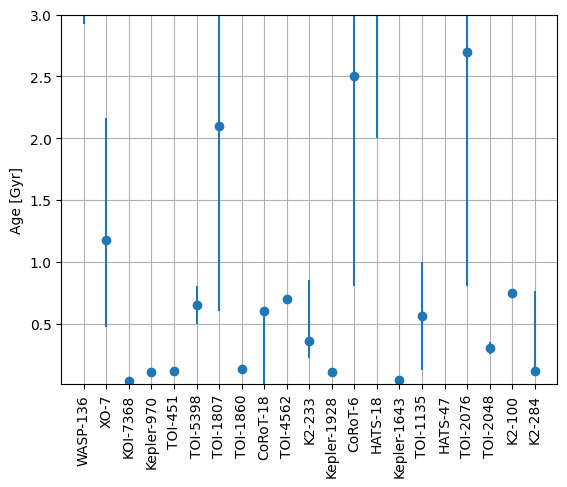

In [18]:
import matplotlib.pyplot as plt

x = known_planets.hostname
y = known_planets.st_age
yerr1 = abs(known_planets.st_ageerr2) #known_planets.st_age+known_planets.st_ageerr2 
yerr2 = known_planets.st_ageerr1 #known_planets.st_age+known_planets.st_ageerr1
plt.errorbar(x, y, yerr=[yerr1, yerr2], marker='o', ls='')
plt.xticks(rotation=90);
# plt.yscale('log')
plt.ylabel('Age [Gyr]')
plt.ylim(0.01, 3)
plt.grid()

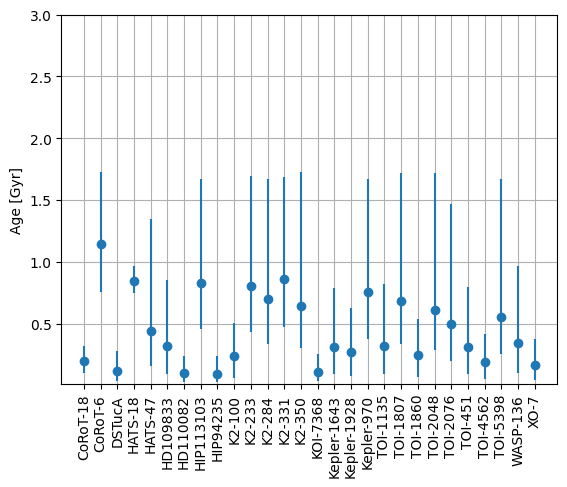

In [19]:
x = gyro_age.hostname
y = gyro_age.age_med/1e3
yerr1 = gyro_age.age_lo/1e3
yerr2 = gyro_age.age_hi/1e3
plt.errorbar(x, y, yerr=[yerr1, yerr2], marker='o', ls='')
plt.xticks(rotation=90);
plt.ylabel('Age [Gyr]')
plt.ylim(0.01, 3)
plt.grid()

## comparison

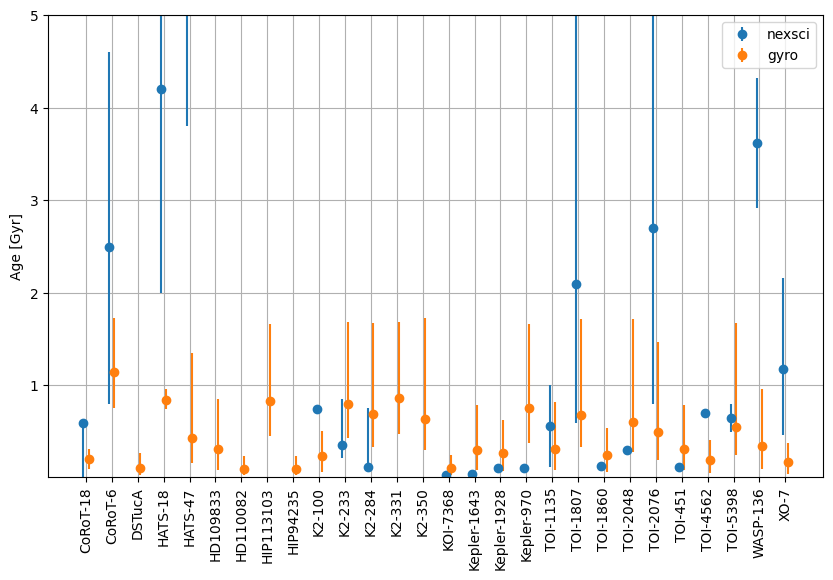

In [48]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))

# Combine hostnames and create x-axis positions
all_hostnames = np.unique(np.concatenate([known_planets.hostname, gyro_age.hostname]))
x_pos = {name: i for i, name in enumerate(all_hostnames)}

# nexsci
x_vals_nexsci = np.array([x_pos[name] for name in known_planets.hostname])
y = known_planets.st_age
yerr1 = abs(known_planets.st_ageerr2)
yerr2 = known_planets.st_ageerr1
plt.errorbar(x_vals_nexsci - 0.1, y, yerr=[yerr1, yerr2], marker='o', ls='', label='nexsci')

# this work
x_vals_gyro = np.array([x_pos[name] for name in gyro_age.hostname])
y = gyro_age.age_med / 1e3
yerr1 = gyro_age.age_lo / 1e3
yerr2 = gyro_age.age_hi / 1e3
plt.errorbar(x_vals_gyro + 0.1, y, yerr=[yerr1, yerr2], marker='o', ls='', label='gyro')

# Adjust x-axis labels
plt.xticks(range(len(all_hostnames)), all_hostnames, rotation=90)
plt.ylabel('Age [Gyr]')
plt.ylim(0.01, 5)
plt.grid()
plt.legend()

In [49]:
name = 'K2-331'
known_planets.query("hostname==@name")[cols]

,hostname,st_age,st_ageerr1,st_ageerr2,st_age_reflink


In [50]:
cols2 = ['hostname','age_med','age_lo','age_hi']
gyro_age.query("hostname==@name")[cols2]

,hostname,age_med,age_lo,age_hi
12,K2-331,861.6,389.94,827.45


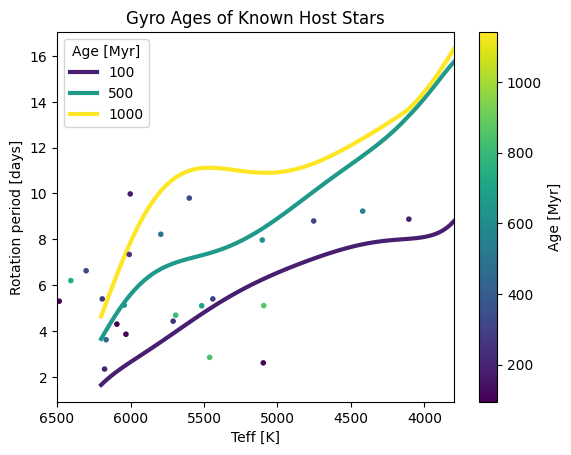

In [52]:
from gyrointerp.models import slow_sequence
from matplotlib.colors import ListedColormap
import numpy as np

tmin, tmax = gyro_age.age_med.min(), gyro_age.age_med.max()
Tmin, Tmax = 3800, 6200
slow_seq_ages = [round(tmin/100)*100,
                 500,
                 round(tmax/1000)*1000]
Nages = len(slow_seq_ages)
Teff = np.linspace(Tmin, Tmax, 100)
colors = ListedColormap(plt.cm.viridis(np.linspace(tmin/tmax, 1, Nages))).colors

fig, ax = plt.subplots()

for i,slow_seq_age in enumerate(slow_seq_ages):
    Prot = slow_sequence(
        Teff, slow_seq_age, poly_order=7,
        interp_method='pchip_m67'
    )
    ax.plot(
        Teff, Prot, color=colors[i], linewidth=3, zorder=-1, label=f"{slow_seq_age}"
    )

# this work
s = ax.scatter(gyro_age.Teff, gyro_age.Prot, marker='.', c=gyro_age.age_med)
# yerr = gyro_age.Prot_
# s = ax.errorbar(gyro_age.Teff, gyro_age.Prot, yerr=[yerrf], xerr=xerr, marker='.', c=gyro_age.age_med)
fig.colorbar(s, label='Age [Myr]')
ax.update({
    'xlabel': 'Teff [K]',
    'ylabel': 'Rotation period [days]',
    'title': 'Gyro Ages of Known Host Stars',
    'xlim': [3800, 6500],
    });
ax.xaxis.set_inverted(True)
ax.legend(title='Age [Myr]', loc='upper left')